In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Exploring optimisation of analytic functions

In [3]:
def rastrigin(X, A=1.0):
    return A*2 + ( (X[0]**2 - A*torch.cos(2*math.pi*X[0])) + (X[1]**2 - A*torch.cos(2*math.pi*X[1])) ) 

In [4]:
xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
xs = np.arange(xmin, (xmax + xstep), xstep)
ys = np.arange(ymin, (ymax + ystep), ystep)
z = rastrigin(torch.tensor([xs,ys]), A=1.0).numpy()

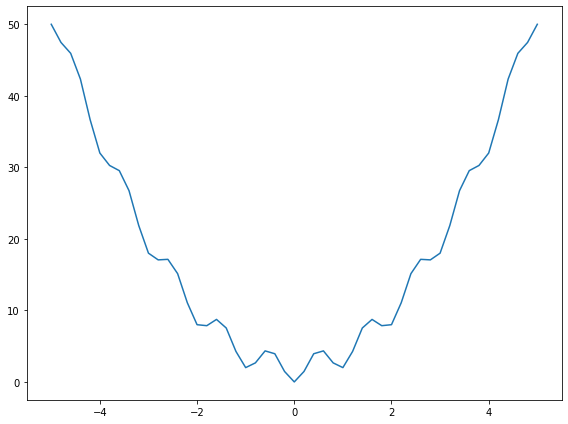

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(xs, z)
plt.tight_layout()
plt.savefig('rastrigin.png')

With $A=1.0$ we find the Rastrigin function has many small 'bumps' or local minima. However the main basin at $x=0$ is the global minimum we want our optimisers to reach.

Parameters initialised:
   tensor([5., 5.], requires_grad=True) torch.FloatTensor
Max epochs:
   100
Initialised SGD:
  Learning rate:0.01
Initialised SGD Momentum:
  Learning rate:0.01, Momentum:0.09
Initialised Adagrad:
  Learning rate:0.01
Initialised Adam:
  Learning rate:0.01
Loss function:
  Rastrigin, A=1.0


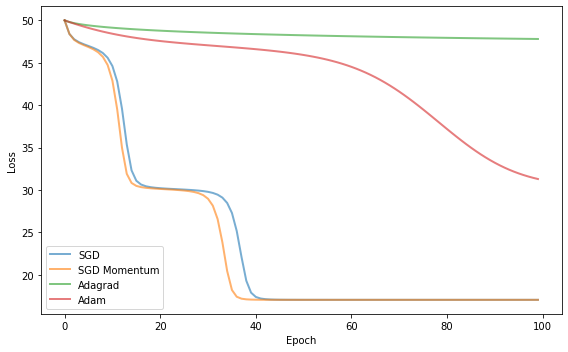

In [7]:
p_SGD = torch.tensor([5.0, 5.0], requires_grad=True, device=device)
p_SGD_Mom = torch.tensor([5.0, 5.0], requires_grad=True, device=device)
p_Adagrad = torch.tensor([5.0, 5.0], requires_grad=True, device=device)
p_Adam = torch.tensor([5.0, 5.0], requires_grad=True, device=device)
print('Parameters initialised:\n  ', p_SGD, p_SGD.type())
epochs = 100
print('Max epochs:\n  ', epochs)
A = 1.0
opt_SGD = torch.optim.SGD([p_SGD], lr=0.01)
print(f'Initialised SGD:\n  Learning rate:{0.01}')
opt_SGD_Mom = torch.optim.SGD([p_SGD_Mom], lr=0.01, momentum=0.09)
print(f'Initialised SGD Momentum:\n  Learning rate:{0.01}, Momentum:{0.09}')
opt_Adagrad = torch.optim.Adagrad([p_Adagrad], lr=0.01)
print(f'Initialised Adagrad:\n  Learning rate:{0.01}')
opt_Adam = torch.optim.Adam([p_Adam], lr=0.01)
print(f'Initialised Adam:\n  Learning rate:{0.01}')

plt_loss_SGD = []
plt_loss_SGD_Mom = []
plt_loss_Adagrad = []
plt_loss_Adam = []

for epoch in range(epochs):
    # zero gradients
    opt_SGD.zero_grad()
    opt_SGD_Mom.zero_grad()
    opt_Adagrad.zero_grad()
    opt_Adam.zero_grad()
    # compute loss
    loss_SGD = rastrigin(p_SGD, A=A)
    loss_SGD_Mom = rastrigin(p_SGD_Mom, A=A)
    loss_Adagrad = rastrigin(p_Adagrad, A=A)
    loss_Adam = rastrigin(p_Adam, A=A)
    # backprop
    loss_SGD.backward()
    loss_SGD_Mom.backward()
    loss_Adagrad.backward()
    loss_Adam.backward()
    # step optimiser
    opt_SGD.step()
    opt_SGD_Mom.step()
    opt_Adagrad.step()
    opt_Adam.step()
    # store loss for plots
    plt_loss_SGD.append(loss_SGD.item())
    plt_loss_SGD_Mom.append(loss_SGD_Mom.item())
    plt_loss_Adagrad.append(loss_Adagrad.item())
    plt_loss_Adam.append(loss_Adam.item())


print(f'Loss function:\n  Rastrigin, A={A}')
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(plt_loss_SGD, label='SGD', linewidth=2, alpha=.6)
ax.plot(plt_loss_SGD_Mom, label='SGD Momentum', linewidth=2, alpha=.6)
ax.plot(plt_loss_Adagrad, label='Adagrad', linewidth=2, alpha=.6)
ax.plot(plt_loss_Adam, label='Adam', linewidth=2, alpha=.6)

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.tight_layout()
plt.savefig('optimiser_comparison_rastrigin.png')

Rastrigin is a difficult function to optimise as it's filled with many local minima, but there is only one global minimum. We find that SGD + Momentum shows the best performance when applied to a 2D Rastrigin function with $A=1.0$ (a parameter which determines how 'bumpy' the function is).

# Optimisation of a SVM on real data


Applying soft-margin SVM to Iris data and optimise its paramters using gradient descent. 

Note: we will only be using two of the four classes from the dataset.

An SVM tries to find the maximum margin hyperplane which separates the data classes. For a soft margin SVM
where $\textbf{x}$ is our data, we minimize:

\begin{equation}
\left[\frac 1 n \sum_{i=1}^n \max\left(0, 1 - y_i(\textbf{w}\cdot \textbf{x}_i - b)\right) \right] + \lambda\lVert \textbf{w} \rVert^2
\end{equation}

We can formulate this as an optimization over our weights $\textbf{w}$ and bias $b$, where we minimize the
hinge loss subject to a level 2 weight decay term. The hinge loss for some model outputs
$z = \textbf{w}\textbf{x} + b$ with targets $y$ is given by:

\begin{equation}
\ell(y,z) = \max\left(0, 1 - yz \right)
\end{equation}

In [8]:
import torch
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [9]:
def svm(x,w,b):
    h = (w*x).sum(1) + b
    return h

In [10]:
def hinge_loss(z, y):
    yz = y * z
    return torch.max(torch.zeros_like(yz), (1-yz))

In [11]:
# test
print(hinge_loss(torch.randn(2), torch.randn(2) > 0).float())

tensor([1.0000, 2.7751])


In [12]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header=None)
df = df.sample(frac=1, random_state=0) # shuffle

df = df[df[4].isin(['Iris-virginica', 'Iris-versicolor'])] # filter

# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = (2 * df[4].map(mapping)) - 1 # labels in {-1,1}

# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

# create datasets
targets_tr = torch.tensor(df.iloc[:75, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[75:, 5].values, dtype=torch.long)
data_tr = alldata[:75]
data_va = alldata[75:]

In [13]:
from torch.utils import data

In [14]:
# mini-batch training data
dataset_tr = data.TensorDataset(data_tr, targets_tr)
dataloader_tr = data.DataLoader(dataset_tr, batch_size=25, shuffle=True)

In [15]:
# mini-batch test data
dataset_va = data.TensorDataset(data_va, targets_va)
dataloader_va = data.DataLoader(dataset_va, batch_size=25, shuffle=True)

In [16]:
def eval_accuracy(predictions, labels):
    a = sum(predictions.detach().numpy() * labels.numpy() >=0) / len(labels)
    return a

In [92]:
def svm_train(train_dataloader, data_va, targets_va, epochs=100, lr=0.01, decay=0.01):
    print('Support Vector Machine:')
    print('  learning_rate:', lr)
    print('  epochs:', epochs)
    train_rows, train_col = train_dataloader.dataset.tensors[0].shape
    print(f'  X_train.shape: ({train_rows},{train_col})')
#     train_y_rows = dataloader.dataset.tensors[1].shape[0]
#     print(f'  y_train.shape: ({train_y_rows})')
#     test_rows, test_col = test_dataloader.dataset.tensors[0].shape
#     print(f'  X_test.shape: ({train_rows},{train_col})')
#     test_y_rows = dataloader.dataset.tensors[1].shape[0]
#     print(f'  y_test.shape: ({test_y_rows})')
    print('---------------------------------')
    # initialise weights and biases
    w = torch.randn(1, train_col, requires_grad=True)
    b = torch.randn(1, requires_grad=True)
    
    optimiser = torch.optim.SGD([w,b], lr=lr, weight_decay=decay)
#     optimiser = torch.optim.Adam([w,b], lr=lr, weight_decay=decay)
    
    # record loss over epoch
    losses = []
    # record training accuracy over epoch
    train_accuracy = []
    # record validation accuracy over epoch
    test_accuracy = []
    
    print('Training model, please wait...')
    for epoch in tqdm(range(epochs)):
        ep_loss = 0
        for train_batch in train_dataloader:
            # zero gradients
            optimiser.zero_grad()
            # compute loss
            X_train, y_train = train_batch
            y_pred = svm(X_train, w, b)
            loss = hinge_loss(y_pred, y_train).mean()
            # backprop
            loss.backward()
            # step optimiser
            optimiser.step()
            # track loss
            ep_loss += loss.item()
        losses.append(ep_loss)
        # training accuracy
        ep_train_pred = svm(X_train, w, b)
        ep_train_acc = eval_accuracy(ep_train_pred, y_train)
        train_accuracy.append(ep_train_acc)
        #   validation accuracy
        ep_test_pred = svm(data_va, w, b)
        ep_test_acc = eval_accuracy(ep_test_pred, targets_va)
        test_accuracy.append(ep_test_acc)

    print(f'Training accuracy: {train_accuracy[-1]*100}%')
    print(f'Validation accuracy: {ep_test_acc*100}%')
    
    print(f'Train loss: {losses[-1]}')
    return train_accuracy, test_accuracy, losses

In [22]:
tr_acc, va_acc, loss = svm_train(dataloader_tr, data_va, targets_va,
                                 epochs=100, lr=0.01, decay=0.01)

Support Vector Machine:
  learning_rate: 0.01
  epochs: 100
  X_train.shape: (75,4)
---------------------------------
Training model, please wait...


  0%|          | 0/100 [00:00<?, ?it/s]

Training accuracy: 92.0%
Validation accuracy: 92.0%
Train loss: 0.40005533397197723


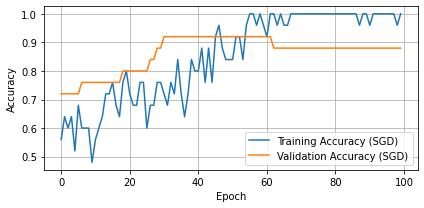

In [189]:
# SGD training accuracy
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(len(tr_acc)), tr_acc, label='Training Accuracy (SGD)')
ax.plot(range(len(va_acc)), va_acc, label='Validation Accuracy (SGD)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('sgd_tr_va_acc.png')

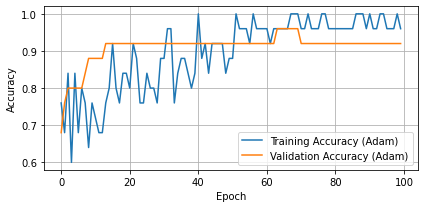

In [193]:
# Adam training accuracy
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(len(tr_acc)), tr_acc, label='Training Accuracy (Adam)')
ax.plot(range(len(va_acc)), va_acc, label='Validation Accuracy (Adam)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('adam_tr_va_acc.png')

In [97]:
tr_acc_SGD, va_acc_SGD, loss_SGD = svm_train(dataloader_tr, data_va, targets_va,
                                 epochs=100, lr=0.01, decay=0.01)

Support Vector Machine:
  learning_rate: 0.01
  epochs: 100
  X_train.shape: (75,4)
---------------------------------
Training model, please wait...


  0%|          | 0/100 [00:00<?, ?it/s]

Training accuracy: 96.0%
Validation accuracy: 88.0%
Train loss: 0.5745970010757446


In [90]:
tr_acc_Adam, va_acc_Adam, loss_Adam = svm_train(dataloader_tr, data_va, targets_va,
                                 epochs=100, lr=0.01, decay=0.01)

Support Vector Machine:
  learning_rate: 0.01
  epochs: 100
  X_train.shape: (75,4)
---------------------------------
Training model, please wait...


  0%|          | 0/100 [00:00<?, ?it/s]

Training accuracy: 96.0%
Validation accuracy: 88.0%
Train loss: 0.2739289551973343


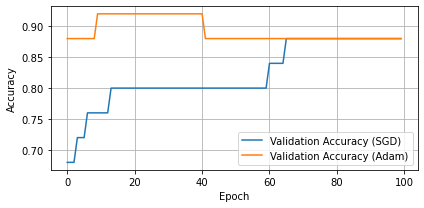

In [98]:
# SGD vs Adam validation accuracy
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(len(va_acc)), va_acc_SGD, label='Validation Accuracy (SGD)')
ax.plot(range(len(va_acc)), va_acc_Adam, label='Validation Accuracy (Adam)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('sgd_vs_adam_acc_1.png')

SGD makes bigger jumps in accuracy whilst Adam makes smaller ones. This results in SGD obtaining higher final validation accuracy.

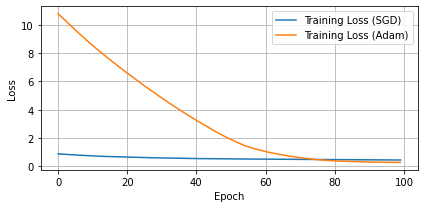

In [199]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(len(loss)), loss_SGD, label='Training Loss (SGD)')
ax.plot(range(len(loss)), loss_Adam, label='Training Loss (Adam)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend(loc='best', frameon=True)
plt.tight_layout()
plt.savefig('sgd_vs_adam_loss.png')

Adam's loss starts off at a very large value and it does a good job of minimising it such that it matches the superior performance of SGD.